# Stay connected 
```
var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End"); 
    };

    var intervalId = setInterval(clickConnect, 60000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();
```

# Memory Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.46GB
Available: 24.60GB
Used: 526.25MB
Percentage: 3.4%


# GPU Information

In [ ]:
! nvidia-smi

Thu Feb 25 14:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Setup**

In [ ]:
# install libraries not in Colab
%%capture
!pip install decord

In [ ]:
# standard sci libraries
import numpy as np
import matplotlib.pyplot as plt

# machine learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.hub as hub
from typing import Union, List, Dict, Any, cast

from torchvision import transforms as trn
from torch.autograd import Variable as V
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# image & video libraries
from decord import VideoReader  
from PIL import Image    

# others
import time
import glob
import os
import pickle

In [ ]:
# random number generators for reproducibility
seed = 24

torch.manual_seed(seed)
np.random.seed(seed)

# **Data loading**

In [ ]:
# download dataset from dropbox
dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0'
os.environ['download_link'] = dropbox_link  
!echo $download_link
!wget -O participants_data.zip -c $download_link
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
--2021-08-08 12:58:39--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/agxyxntrbwko7t1/participants_data.zip [following]
--2021-08-08 12:58:40--  https://www.dropbox.com/s/raw/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc649bf93b7bb08afeb287c313d0.dl.dropboxusercontent.com/cd/0/inline/BT2auM6oXoCdGEZR-DE30oxoTHacOLS96ZSWD2uG-yJaUadF-e3Y2a3XoolgPmTQPjQoGhoijMVAeuEgmBHTqMW8TQOexBIiWHSY9Lhp43TIJHhv59uT_XViN2Sb_Ud_g4XdQvaOdjCauM52RDjxPRU8/file# [following]
--2021-08-08 12:58:40--  https://uc649bf93b7bb08afeb287c313d0.dl.dropboxusercontent.com/c

In [ ]:
# unzip data file (%%capture suppresses the output)
%%capture
!unzip -o participants_data.zip

# **Video preprocessing**

In [ ]:
# Colab directory containing videos
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

# get path of all videos
video_list = glob.glob(video_dir + '/*.mp4')

# sort videos in ascending order
video_list.sort()

print('Total number of videos: ', len(video_list))

Total number of videos:  1102


In [ ]:
def sample_video_from_mp4(file, num_frames = 16):
    """This function takes a mp4 video file as input and returns
    an array of uniformly sampled frames.
    
    Args
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        number of frames to select with uniform frame sampling
    
    Returns
    -------
    frames: list of frames as PIL images
    num_frames: number of sampled frames

    """
    
    # read video file
    video = VideoReader(file)

    # get total number of video frames
    total_frames = len(video)

    # create frame indices 
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype = np.int) 

    video_frames = []

    # fill list of video frames as PIL images
    for i in frame_indices:
      video_frames.append(Image.fromarray(video[i].asnumpy()))

    return video_frames, num_frames


In [ ]:
# example of using the previous function
example_frames, num_frames = sample_video_from_mp4(video_list[8])
len(example_frames)

16

# **Neural network feature extraction**

## Pretrained model

In [ ]:
__all__ = ['VGG', 'vgg19_bn', 'vgg19']


model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
    }


class VGG19(nn.Module):

    def __init__(self, num_classes = 1000):
        super(VGG19, self).__init__()
        
        self.layers = nn.ModuleList([nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ),
        nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ),
        nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ),
        nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ),
        nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096, bias=True),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True)
        ),
        nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        )])


    def forward(self, x):
        
        activations = []
          
        for i, layer in enumerate(self.layers): 
            if i == 0:
                activations.append(layer(x))
            elif i == 16:
                out15_reshaped = activations[i-1].view(activations[i-1].size(0), 512 * 7 * 7)
                activations.append(layer(out15_reshaped))
            else:
                activations.append(layer(activations[i-1]))  

        return activations


In [ ]:
def load_model(model_url):
    """This function initializes a neural network (VGG19) and load
    its weights from a pretrained model.
    
    Args:
        arch: class
            pytorch neural network.
        model_url: str
            pytorch model. 

    Returns:
        model: class
            pytorch model ready for inference.
    """

    # instantiate model architecture
    model = VGG19()
    
    # list of parameters name of the model
    param_names = list(model.state_dict())  

    # initialise dictionary of model parameters
    model_dict = {k:None for k in param_names}

    # load parameters of pretrained model
    state_dict = hub.load_state_dict_from_url(model_url)
    
    i = 0
    for v in state_dict.values():
        model_dict[param_names[i]] = v
        i += 1

    model.load_state_dict(model_dict)
    
    # gpu availability
    if torch.cuda.is_available():
        model.cuda()

    # set inference mode
    model.eval()

    return model

In [ ]:
vgg19 = load_model(model_urls['vgg19'])

## Model activations

In [ ]:
def get_activations_and_save(model, video_list, save_dir, layer):
    """This function extracts the activations (features) of a specific layer of
    a model to a set of videos and save them in a specified directory. Every
    file is a list with a vector containing the activations of that layer to
    a particular video. The activations are averaged over the frames of every
    video. 

    Parameters
    ----------
    model :
        pytorch model.
    video_list : list
        list containing path to all videos.
    save_dir : str
        save path for extracted activations.
    layer : int
        integer specifying layer number.
    """
    
    # define preprocessing function
    preprocess = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for i, video in enumerate(video_list):

      # name video file
      video_file_name = os.path.split(video)[-1].split(".")[0]
      
      # load video frames
      video_frames, num_frames = sample_video_from_mp4(video)
      
      activations = []
      for frame, image in enumerate(video_frames):

        # preprocess video frame
        input_image = V(preprocess(image).unsqueeze(0))
        
        # put image onto gpu if available
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        
        # feed image through the model
        layer_outputs = model.forward(input_image)

        if frame==0:
          # append and flatten layer activations
          activations.append(layer_outputs[layer].ravel())
        else:
          # add activations over frames
          activations[0] = activations[0] + layer_outputs[layer].ravel()
        
        # average layer activations across frames
        avg_layer_activations = np.array([activations])/float(num_frames)
        
        # define saving directory
        save_path = os.path.join(save_dir, video_file_name + "_" +
                               "layer" + "_" + str(layer) + ".npy")

        # save activations for a particular video
        np.save(save_path, avg_layer_activations)


In [ ]:
############################### change dir ###########################
# create saving directory for activations
activations_dir = "/content/activations_vgg19"
if not os.path.exists(activations_dir):
  os.makedirs(activations_dir)

# get activations
get_activations_and_save(vgg19, video_list, activations_dir, layer = 18)   ##### SPECIFY LAYER NUMBER #####

## Perform PCA on activations

In [ ]:
def do_PCA_and_save(activations_dir, save_dir): 
    """This function preprocesses a neural network's features using PCA and
    save the results in a specified directory.

    Parameters
    ----------
    activations_dir : str
        save path for extracted activations.
    save_dir : str
        save path for extracted PCA features.
    """

    # number of PCA components
    n_components = 100     
        
    # get path of activations of a layer to all videos
    activations_file_list = glob.glob(activations_dir + '/*.npy')
    # sort activations in ascending order
    activations_file_list.sort()
    # load one activation to later get dimension
    feature_dim = np.load(activations_file_list[0], allow_pickle=True)[0][0].shape[0]
        
    # initialise data matrix for PCA - #videos x layer dimension
    x = np.zeros((len(activations_file_list), feature_dim))
        
    # fill matrix with activations of every video (for a given layer)
    for i, video_activations in enumerate(activations_file_list):
        temp = np.load(video_activations, allow_pickle=True)[0][0].detach().numpy()
        x[i,:] = temp
        
    # train-test split
    x_train = x[:1000,:]
    x_test = x[1000:,:]

    print("Scaling data")
    # scale training and test sets
    x_train = StandardScaler().fit_transform(x_train)
    x_test = StandardScaler().fit_transform(x_test)

    print("Fitting PCA")
    # find principal components of training set
    pca = PCA(n_components = n_components, random_state = seed)
    pca.fit(x_train)

    print("Projecting data onto components")
    # project data onto components - #videos x #components 
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    print("Saving")
    # create saving directory
    train_save_path = os.path.join(save_dir, "train_layer_19")  ############ SPECIFY LAYER NUMBER #######
    test_save_path = os.path.join(save_dir, "test_layer_19")

    # save results
    np.save(train_save_path, x_train)
    np.save(test_save_path, x_test)
        

In [ ]:
# create saving directory for pca features
pca_dir = '/content/pca_activations'
if not os.path.exists(pca_dir):
  os.makedirs(pca_dir)

# call function to get dimensionality-reduced activations
do_PCA_and_save(activations_dir, pca_dir)

Scaling data
Fitting PCA
Projecting data onto components
Saving


# **Regression on fMRI data**

In [ ]:
#@title Helper functions for data loading


# loading function for pickle ROI file
def load_dict(filename_):
    # read file in bytes
    with open(filename_, 'rb') as f:
        # create pickle object
        u = pickle._Unpickler(f)
        # # change encoding appropriate for numpy array
        u.encoding = 'latin1'
        # load it
        ret_di = u.load()
        
    return ret_di


def get_fmri(fmri_dir, sub, ROI):
    """This function loads fMRI data into a numpy array for a given
    participant and ROI.
    
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    sub : str
        participant number path
    ROI : str
        name of ROI.

    Returns
    ---------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI.
    """

    # Load ROI data
    ROI_file = os.path.join(fmri_dir, sub, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)

    return ROI_data_train


def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed
    using PCA) into a numpy array according to a given layer.
    
    Parameters
    ----------
    activations_dir : str
        path to PCA/processed neural network features
    layer_name : str
        which layer of the neural network to load
    
    Returns
    ---------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    """

    # load training and test file of a given layer
    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    #test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    #test_activations = np.load(test_file)

    # scale training and test activations
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    #test_activations = scaler.fit_transform(test_activations)

    return train_activations

In [ ]:
#@title Correlation function for model validation

def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

In [ ]:
def perform_encoding(pca_dir, fmri_dir, results_dir, layer, sub, ROI,
                     batch_size=1000):
  """This function linearly regresses pca-reduced features/activations of a
  given layer of a neural network to the fMRI activity of a given brain region
  (ROI) in a given subject. The fitted model is used to predict part of the
  training set (validation mode). The model predictions are saved in a specified
  directory. 
  
  # Arguments
  -------------
  pca_dir : str
      path to PCA features.
  fmri_dir : str
      path to fMRI data.
  results_dir : str
      saving directory for results.
  layer : str
      layer name from which to extract activations.
  sub : str
      participant number path.
  ROI : str
      region of interest (brain region) from which to extract fMRI data.
  batch_size : int
      Number of voxels processed when fitting the linear regressor. 1000 by
      default.

  """

  # load train activations
  train_activations = get_activations(pca_dir, layer)
  
  # load fMRI data for a given subject and ROI
  fmri_train_all = get_fmri(fmri_dir, sub, ROI)
  # get number of voxels for given ROI
  num_voxels = fmri_train_all.shape[1]

  # create training and validation sets
  val_activations = train_activations[900:,:]       ################ adjust splits according to #videos ###############
  train_activations = train_activations[:900,:]    
  fmri_train = fmri_train_all[:900,:]
  fmri_val = fmri_train_all[900:,:]      

  # initialise results - #validation videos x #voxels
  pred_fmri = np.zeros_like(fmri_val)
  pred_fmri_save_path = os.path.join(results_dir)  ##### removed subject and ROI #####

  # perform multiple multivariate regression
  reg = MultiOutputRegressor(LinearRegression()).fit(train_activations, fmri_train)
  pred_fmri = reg.predict(val_activations)
  
  # correlation between validation predictions and ground truth
  corr = vectorized_correlation(fmri_val, pred_fmri)
  print("----------------------------------------------------------------------------")
  # get mean correlation
  voxelwise_corr = round(corr.mean(), 6)
  print("Mean correlation for ROI : ",ROI," in ",sub," using ",layer," is :", voxelwise_corr)
  
  # save results
  np.save(pred_fmri_save_path, pred_fmri)

  return voxelwise_corr


In [ ]:
# specify create fmri directory
fmri_dir = '/content/participants_data_v2021/mini_track' 

# create saving directory for results
prediction_dir = '/content/model_predictions'
if not os.path.exists(prediction_dir):
  os.makedirs(prediction_dir)

In [ ]:
# list of subjects, ROIs, model and layers
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["V1","V2","V3","V4","LOC","EBA","FFA","STS","PPA"]

In [ ]:
##############################
#### CHANGE LAYER NUMBER #####
layer = 'layer_19'
##############################

In [ ]:
# loop across subjects and layers
voxelwise_corrs = np.zeros((len(subs), len(ROIs)))

for i, sub in enumerate(subs):
  for j, ROI in enumerate(ROIs):
    # make prediction
    print("Starting ROI: ", ROI, "sub: ", sub)
    voxelwise_corrs[i, j] = perform_encoding(pca_dir, fmri_dir, prediction_dir,
                                        layer = layer, sub = sub, ROI = ROI)
    print ("Completed ROI: ", ROI, "sub: ", sub)
    print("----------------------------------------------------------------------------")

# create saving directory
all_prediction_dir = os.path.join(prediction_dir, 'mean_correlation_all_subs_all_ROIs_with_' + layer)
np.save(all_prediction_dir, voxelwise_corrs)

Starting ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V1  in  sub01  using  layer_19  is : 0.106415
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V2  in  sub01  using  layer_19  is : 0.139367
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V3  in  sub01  using  layer_19  is : 0.165812
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :

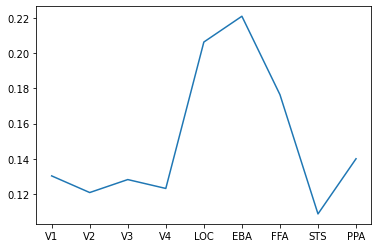

In [ ]:
subjs_mean = np.mean(voxelwise_corrs, axis = 0)
subjs_std = np.std(voxelwise_corrs, axis = 0)
plt.plot(ROIs, subjs_mean)

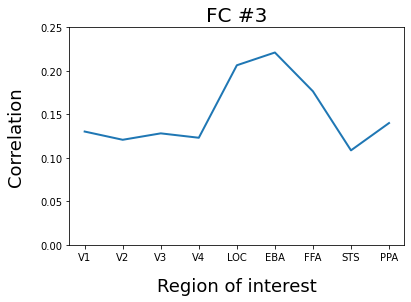

In [ ]:
plt.plot(ROIs, subjs_mean, linewidth=2)
plt.title('FC #3', fontsize = 20)
plt.xlabel('Region of interest', fontsize=18, labelpad=15)
plt.ylabel('Correlation', fontsize=18, labelpad=15)
plt.ylim([0, 0.25])
plt.savefig('Prediction_with_VGG19_layer_19.pdf', bbox_inches='tight')